In [117]:
import pandas as pd
import os
import re 
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

#### Clarification on column names: 
"tot_masks_trained": Total number of masks used in training

"num_masks": After MCMC, masks will have a different probability based on the amount they were accepted. This column represent the amount of the 'top-k' masks we are using on inference. (i.e for using num_masks=k masks amongst n total masks trained on, we run inference using a weighted average of k/n masks)

"dropout_probs1": Dropout probability on layer 1

"dropout_probs2": Dropout probability on layer 2

"num_groups": Number of partitioned groups for masks to train off of

"increment_amt": amount to increment each mask when using MCMC

In [9]:
column_names = ["tot_masks_trained", "num_masks",
    "test_accuracy",
    "EPOCHS",
    "BATCH_SIZE",
    "LR",
    "dropout_probs1",
    "dropout_probs2",
    "num_groups",
    "increment_amt"]
df = pd.DataFrame(columns=column_names)

In [10]:
for folder in os.listdir("experiments"):
    path = os.path.join("experiments", folder)
    # adding this because I forgot to add number of masks trained on in the csv
    match = re.findall(r'\d+', folder.split("_")[0])[-1] 
    if "results.csv" not in os.listdir(path=path):
        continue
    new_df = pd.read_csv(os.path.join(path, "results.csv"))
    new_df["tot_masks_trained"] = match
    df = pd.concat([df, new_df])


/var/folders/5q/7b4nn19d1rj3vsg11yxvc8lw0000gn/T/ipykernel_5744/2272338392.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df])


## Analysis of dropout masks


High dropout probabilities do have the ability of yielding stronger performance. It would seem; however, there is a caveat that there must be fewer masks (but not necessarily only one) that we train on in general. 

I would hypotheisize that too many independent masks trying to train on their own end up adding too much noise to weights and don't allow them to learn meaningful representations.

For this particular architecture (hidden layer size (512, 256)) it seems that 3 masks yields results that are somewhat close to a standard deep-net which uses all neurons (i.e dropout probabiltieies of [0.0, 0.0])

In [19]:
df[(df['test_accuracy'] > 0.89) & (df['dropout_probs1'] >= 0.7) & \
   (df['dropout_probs2'] >= 0.4)].sort_values(by="test_accuracy").tail(20)

,tot_masks_trained,num_masks,test_accuracy,EPOCHS,BATCH_SIZE,LR,dropout_probs1,dropout_probs2,num_groups,increment_amt
3,3,3,0.8963,12,32,0.001,0.7,0.7,1,10
3,3,3,0.8963,12,32,0.001,0.7,0.7,1,50
3,3,3,0.8963,12,32,0.001,0.7,0.7,1,1
2,3,2,0.9017,12,32,0.001,0.7,0.4,1,1
2,3,2,0.9017,12,32,0.001,0.7,0.4,1,50
2,3,2,0.9017,12,32,0.001,0.7,0.4,1,10
3,3,3,0.9085,12,32,0.001,0.7,0.4,1,1
3,3,3,0.9085,12,32,0.001,0.7,0.4,1,50
3,3,3,0.9085,12,32,0.001,0.7,0.4,1,10


## top performing hyperparameters

Dropout, of 0.7 and 0.4 is actually realtively strong in this case. See the end of experiments-deep/mask_training.ipnyb for more information  pruning

In [35]:
df.drop(['increment_amt'], axis=1).drop_duplicates().sort_values(by="test_accuracy").head(10)

,tot_masks_trained,num_masks,test_accuracy,EPOCHS,BATCH_SIZE,LR,dropout_probs1,dropout_probs2,num_groups
0,3,0,0.098,12,32,0.001,0.4,0.4,1
0,3,0,0.098,12,32,0.001,0.2,0.4,1
0,3,0,0.098,12,32,0.001,0.4,0.7,1
0,1,0,0.098,12,32,0.001,0.7,0.7,1
0,1,0,0.098,12,32,0.001,0.4,0.4,1
0,3,0,0.098,12,32,0.001,0.7,0.4,1
0,1,0,0.098,12,32,0.001,0.7,0.4,1
0,3,0,0.098,12,32,0.001,0.7,0.2,1
0,1,0,0.098,12,32,0.001,0.4,0.7,1
0,1,0,0.098,12,32,0.001,0.0,0.0,1


In [ ]:
df.drop_duplicates().sort_values(by="test_accuracy")('increment_amt', axis=1).tail(5)

TypeError: 'DataFrame' object is not callable

In [85]:
new_df = df.drop(['increment_amt'], axis=1).drop_duplicates().sort_values(by="test_accuracy")

In [86]:
new_df.head()

,tot_masks_trained,num_masks,test_accuracy,EPOCHS,BATCH_SIZE,LR,dropout_probs1,dropout_probs2,num_groups
0,3,0,0.098,12,32,0.001,0.4,0.4,1
0,3,0,0.098,12,32,0.001,0.2,0.4,1
0,3,0,0.098,12,32,0.001,0.4,0.7,1
0,1,0,0.098,12,32,0.001,0.7,0.7,1
0,1,0,0.098,12,32,0.001,0.4,0.4,1


In [87]:
probs = [0.2, 0.4, 0.7]
cartesian_product = list(product(probs, probs))
new_df = new_df[new_df['num_masks'] > 0.1]
new_df['tot_masks_trained'] = new_df['tot_masks_trained'].astype(int)
new_df['num_masks'] = new_df['num_masks'].astype(int)

In [126]:
def get_rows(prob1, prob2):
    curr_df = new_df[((new_df['dropout_probs1'] == prob1) & (new_df['dropout_probs2'] == prob2))]
    curr_df = curr_df[curr_df['tot_masks_trained'] == curr_df['num_masks']][['num_masks', 'dropout_probs1', 'dropout_probs2', 'test_accuracy']]
    return curr_df.sort_values("num_masks")

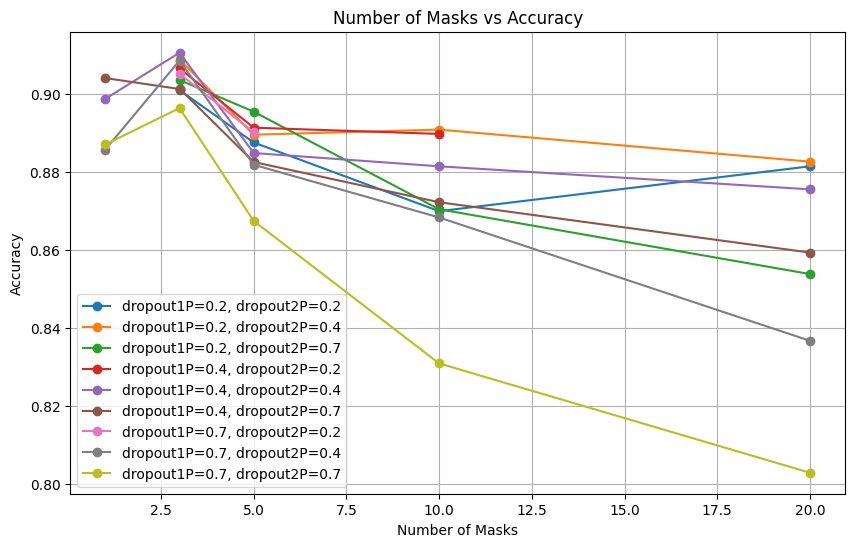

,num_masks,dropout_probs1,dropout_probs2,test_accuracy
1,1,0.7,0.7,0.8870
3,3,0.7,0.7,0.8963
3,5,0.7,0.7,0.8674
4,10,0.7,0.7,0.8309
4,20,0.7,0.7,0.8029


In [128]:
plt.figure(figsize=(10, 6))

for prob1, prob2 in cartesian_product:
    x = get_rows(prob1, prob2)
    if not x.empty:
        plt.plot(x['num_masks'], x['test_accuracy'], label=f'dropout1P={prob1}, dropout2P={prob2}', marker='o')

plt.xlabel('Number of Masks')
plt.ylabel('Accuracy')
plt.title('Number of Masks vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()
x